**프로젝트 : Finance Time Series 데이터 활용하기**

프로젝트 요약
___
1. 프로젝트 : Data Labeling
2. 프로젝트 : Feature Engineering
3. 프로젝트 : Model Training
___

이번 노드에서 프로젝트는 총 3가지로 구성되어있습니다. Data Labeling 방법과 Feature Engineering 방법에 대해 생각해보며 model training을 통해 성능을 개선시켜봅시다.

- 프로젝트 1, 2를 정상적인 흐름대로 진행하기
- 프로젝트 3에서 다양한 방법을 사용하여 기존의 결과와 비교 분석 시도하기
- 다양한 방법을 사용하여 성능향상을 시도하기

앞에서 했던 내용을 기억하면서 코드를 작성해봅시다.

# 1. 프로젝트 : Data Labeling
___
위에서 배운 Data Labeling 4가지를 직접 적용해봅시다.

  ① Price Change Direction 적용하기  
  ② Using Moving Average 적용하기  
  ③ Local Min-Max 적용하기  
  ④ Trend Scanning 적용하기  
___

앞에서 진행한 Data Labeling 방법은 4가지가 있었습니다.

먼저 필요한 라이브러리 및 패키지를 확인 후 실행합니다. 다음은 데이터가 저장된 경로에서 데이터를 불러온 뒤 필요한 부분을 확인하기 위해 시각화를 진행합니다.

In [2]:
!pip install ta==0.9.0 shap

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28893 sha256=fe8e9b68d47b921316dd712a03b642b23823b378fbe2dbce058c4209a9e3644c
  Stored in directory: /root/.cache/pip/wheels/41/9d/74/9461cc3506f46d0ab93664f8168d974d944b57bb15f24d9e55
Successfully built ta


In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# 데이터 경로
DATA_PATH = '/content/drive/MyDrive/DS/6.시계열/data/시계열_플젝'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)
modify_data

,open,high,low,close,volume
time,,,,,
2017-09-25 03:00:00,324500,325500,322000,324000,52.477251
2017-09-25 03:01:00,324000,324000,322500,324000,39.061889
2017-09-25 03:02:00,322500,324500,322500,324500,12.794000
2017-09-25 03:05:00,324000,324000,323000,324000,33.365246
2017-09-25 03:06:00,324000,325000,322500,324000,46.224544
...,...,...,...,...,...
2019-11-03 10:29:00,212650,212800,212600,212800,30.996276
2019-11-03 10:30:00,212800,212800,212600,212600,3.224132
2019-11-03 10:31:00,212600,212600,212400,212400,135.351681


In [ ]:
modify_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000000 entries, 2017-09-25 03:00:00 to 2019-11-03 10:33:00
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1000000 non-null  int64  
 1   high    1000000 non-null  int64  
 2   low     1000000 non-null  int64  
 3   close   1000000 non-null  int64  
 4   volume  1000000 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 45.8 MB


Data Description
___
- 분석 데이터는 암호화페 거래소인 `업비트의 이더리움 시세 데이터`로, 총 5개의 feature, 100만개의 레코드로 구성되어 있음
- `2017-09-25 03:00`부터 `2019-11-03 10:33`까지 1분 간격의 index를 가지고 있음
- time index 기준으로 value가 저장된 형태이므로 시계열 데이터로 볼 수 있음
- 각 feature별 설명은 다음과 같음
  - `open` : 시가
  - `high` : 고가
  - `low` : 저가
  - `close` : 종가
  - `volumne`: 거래량

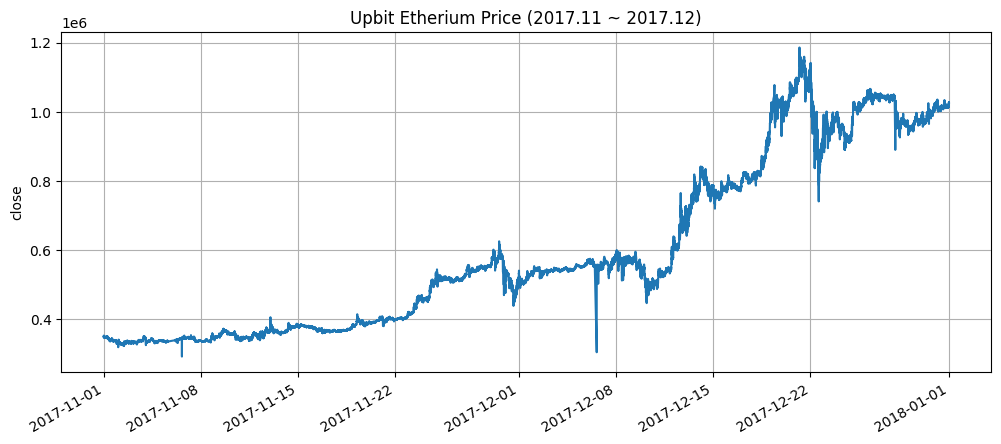

In [ ]:
# 불러온 데이터 시각화하기
plt.figure(figsize=(12,5))

modify_data.loc['2017-11-01':'2017-12-31','close'].plot()
plt.title('Upbit Etherium Price (2017.11 ~ 2017.12)')
plt.xlabel(""); plt.ylabel('close')
plt.grid(axis='both')

## ① Price Change Direction 적용하기
아래의 수식을 적용하여 momentum_signal을 만들어봅시다. 그리고 기존의 데이터(modify_data)와 수식이 적용된 데이터(momentum_signal)를 시각화하여 어떤 차이가 있는지 비교해봅시다.

$$  i(t) =
\begin{cases}
1, & \text{if } price_t - price_{t-n} > 0 \\
0, & \text{if else}
\end{cases}$$

먼저 window를 설정합니다. 보통 window는 시계열 데이터에서 이전 시점과 현재 시점간의 간격을 구간별로 잘라서 사용하곤 합니다.

이렇게 사용하는 이유는 정확한 예측을 달성하기 위해 우리가 가지고 있는 정보를 과거로부터 주어진 시점에서 가능한 안전하게 보존된 정보를 모델에 제공하기 위해 Window로 다시 구성한 다음 모델에 input으로 주입하는 것입니다.

window는 보통 time series data 외에도 많이 사용하는 기법입니다.(ex. 정렬 알고리즘, CNN의 sliding 등...)



In [ ]:
# window 지정
window = 30 # 구간크기: 30분

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) +1) # modify_data['close'].shift(window)활용

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal) # 데이터 활용을 위해 pd.Series를 사용합니다.

기존의 데이터(modify_data)에서 필요한 close(종가)를 가져오고 수식이 적용된 데이터(s_momentum_signal)의 종가와 얼마나 차이가 있는지 확인하기 위해 데이터를 변환하고 시각화합니다.






In [ ]:
s_momentum_signal.loc['2017-11-21'].min(), s_momentum_signal.loc['2017-11-21'].max()

(0.0, 1.0)

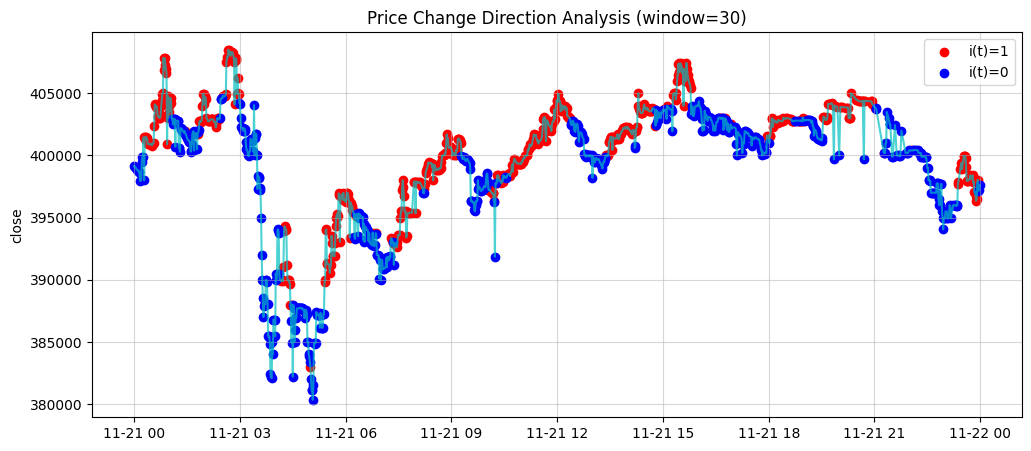

In [ ]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close'] # loc를 활용하여 2017-11-21부터 close(종가)까지 가져오기

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21'] # loc를 활용하여 2017-11-21의 시간대별 값을 가져오기

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue') # np.where 사용

# 시각화하기
plt.figure(figsize=(12,5))

plt.plot(sub_data, color='c', alpha=0.7)
plt.scatter(sub_data.index[c_sig['color'] == 'red'], sub_data[c_sig['color'] == 'red'], c='red', label='i(t)=1')
plt.scatter(sub_data.index[c_sig['color'] == 'blue'], sub_data[c_sig['color'] == 'blue'], c='blue', label='i(t)=0')
plt.title(f"Price Change Direction Analysis (window={window})")
plt.xlabel(""); plt.ylabel('close')
plt.grid(axis='both', alpha=0.5)
plt.legend()

위 그래프는 **2017년 11월 21일** 하루 동안의 이더리움 종가 데이터를 활용하여, 각 시점의 가격이 "Price Change Direction" 방법에 따라 라벨링된 결과를 색상으로 나타낸 그래프이다.
- 빨간색 점 (i(t)=1): 이 시점의 가격이 window 이전의 가격보다 컸음을 의미한다.
-  파란색 점 (i(t)=0): 이 시점의 가격이 window 이전의 가격보다 작았음을 의미한다.

가격이 크게 하락하는 구간에서는 파란색 점들이 집중되어 있고, 가격이 상승하는 구간에서는 빨간색 점들이 나타나는 것을 확인할 수 있다.



## ② Using Moving Average 적용하기
___
앞서 사용했던 이동평균선을 이용한 방식을 적용해봅시다. 수식은 아래과 같습니다.

$$  i(t) =
\begin{cases}
1, & \text{if } price_t > MA(t, \cdots, t-n) \\
0, & \text{if else}
\end{cases}$$


In [ ]:
# window 지정
window = 30 # 구간크기: 30분

# momentum_signal
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) +1) # modify_data['close'].rolling(window).mean() 활용

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal) # pd.Series로 변환

s_momentum_signal.min(), s_momentum_signal.max()

(0.0, 1.0)

앞서 "① Price Change Direction 적용하기"에서 진행했던 것처럼 시각화를 위해 Using Moving Average 수식을 적용한 것과 비교하기 위해 데이터를 변환하여 시각화를 통해 확인합니다.






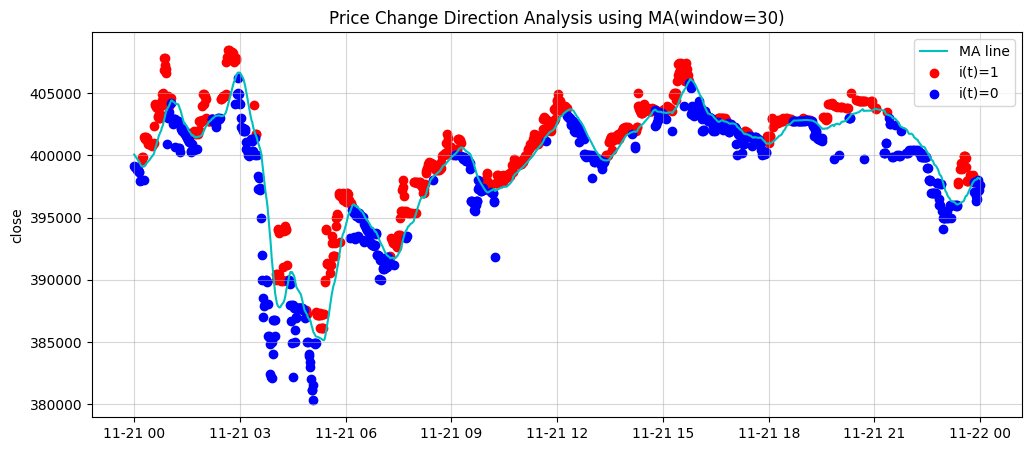

In [ ]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(12,5))

plt.plot(modify_data['close'].rolling(window).mean().loc['2017-11-21'].sort_index(), color='c', label = 'MA line')
plt.scatter(sub_data.index[c_sig['color'] == 'red'], sub_data[c_sig['color'] == 'red'], c='red', label='i(t)=1')
plt.scatter(sub_data.index[c_sig['color'] == 'blue'], sub_data[c_sig['color'] == 'blue'], c='blue', label='i(t)=0')
plt.title(f"Price Change Direction Analysis using MA(window={window})")
plt.xlabel(""); plt.ylabel('close')
plt.grid(axis='both', alpha=0.5)
plt.legend()

위 그래프는 **2017년 11월 21일** 하루 동안의 이더리움 종가 데이터를 **이동평균(window=30)을 적용** 후 라벨링된 결과를 색상으로 나타낸 그래프이다.
- 회색 라인 (MA line): 이동평균에 대한 그래프를 의미한다.
- 빨간색 점 (i(t)=1): 이 시점의 가격이 이동평균값보다 높음을 의미한다.
- 파란색 점 (i(t)=0): 이 시점의 가격이 이동평균값보다 낮거나 같음을 의미한다.


"① Price Change Direction Analysis" 그래프와 마찬가지로 가격이 크게 하락하는 구간에서는 파란색 점들이 집중되어 있고, 가격이 상승하는 구간에서는 빨간색 점들이 나타나는 것을 확인할 수 있다.



## ③ Local Min-Max 적용하기
최소 - 최대 구간을 이어나가며 Labeling하는 함수를 아래 수도코드(pseudo-code)를 보고 만들어봅시다.

```
𝐼𝑛𝑖𝑡𝑖𝑎𝑙𝑖𝑧𝑒 𝑣𝑎𝑟𝑖𝑎𝑏𝑙𝑒𝑠𝑓𝑜𝑟 𝑖 𝑖𝑛 𝑑𝑎𝑡𝑎𝑠𝑒𝑡:
    𝑖𝑓 𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒<𝑝𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
        𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒←𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒
        𝑝𝑎𝑠𝑠𝑖𝑛𝑔 𝑡ℎ𝑟𝑜𝑢𝑔ℎ 𝑡ℎ𝑒 𝐹𝑎𝑙𝑙𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑎𝑐𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑒𝑠𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
    𝑖𝑓 𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒>𝑝𝑟𝑒𝑣𝑖𝑜𝑢𝑠𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
        𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒←𝑐𝑢𝑟𝑟𝑒𝑛𝑡𝑝𝑟𝑖𝑐𝑒
        𝑝𝑎𝑠𝑠𝑖𝑛𝑔 𝑡ℎ𝑟𝑜𝑢𝑔ℎ 𝑡ℎ𝑒 𝑅𝑖𝑠𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑎𝑐𝑐𝑢𝑚𝑢𝑙𝑎𝑡𝑒𝑠𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
    𝑖𝑓 𝑒𝑛𝑑𝑠 𝑡ℎ𝑒 𝐹𝑎𝑙𝑙𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒←𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒
    𝑖𝑓 𝑒𝑛𝑑𝑠 𝑡ℎ𝑒 𝑅𝑖𝑠𝑖𝑛𝑔 𝑇𝑟𝑒𝑛𝑑
        𝑚𝑖𝑛𝑝𝑟𝑖𝑐𝑒←𝑚𝑎𝑥𝑝𝑟𝑖𝑐𝑒
```
①~⑦까지 코드를 자세히 들여다보고 어떠한 방식으로 코드가 동작되는지 뜯어봅시다.  

⑧ return 값은 dictionary 형태로 2개의 DataFrame이 반환되어야합니다.

In [ ]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0] # ①
    n_cnt_min, n_cnt_max = 0, 0

    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False

    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True

        if val > max_value:
            max_value = val # ②
            maxes.append(max_value)  # ③
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True # ④

        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0

        if not b_min_update:
            b_max_update = False # ⑤
            n_cnt_max += 1 # ⑥
            if n_cnt_max >= wait:
                min_value = max_value # ⑦
                n_cnt_max = 0

    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes}) # ⑧

get_local_min_max 함수를 사용하면 return 값이 2개가 나오게 됩니다. 아래 주석을 제거하여 min과 maxes의 값이 어떻게 나오는지 확인해봅시다.






In [ ]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


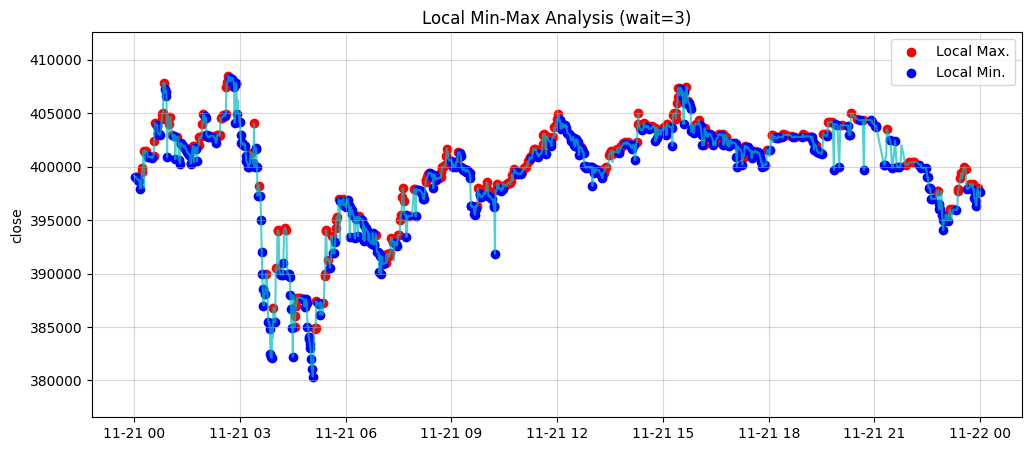

In [ ]:
# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(sub_data.sort_index(), color='c', alpha=0.7)

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes.max_time, maxes.local_max, c='red', label = 'Local Max.')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins.min_time, mins.local_min, c='blue', label = 'Local Min.')

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

ax.set_title(f"Local Min-Max Analysis (wait=3)")
ax.set_ylabel('close')
ax.grid(axis='both', alpha=0.5)
ax.legend()

위 그래프는 **2017년 11월 21일** 하루 동안의 이더리움 종가 데이터에 `get_local_min_max` 함수를 적용 후 라벨링된 Local Min/Max 결과를 색상으로 나타낸 그래프이다.
- 빨간색 점 (Local Max.): 지역 최대값으로 판별된 점들로 하락 추세로 전환될 가능성이 있는 변곡점을 의미한다
- 파란색 점 (Local Min.): 지역 최소값으로 판별된 점들로 상승 추세로 전환될 가능성이 있는 변곡점을 의미한다




## ④ Trend Scanning 적용하기
___
Trend Scanning을 구현해봅시다.
  $$x_{t+l} = \beta_0 + \beta_1 * l + \epsilon_{t+l} $$

  $$\hat{t}_{\beta_1} = \frac{\beta_1}{\sigma_{\beta_1}} $$

$$ Label \, i(t) =
\begin{cases}
1, & \text{if max} \, \hat{t}_{\beta_1} > 0 \\
0, & \text{if else}
\end{cases}$$

OLS는 회귀분석을 하는 경우 유용하게 사용할 수 있으며 아래 함수에서 ols.tvalue를 통해 t-value값을 사용할 수 있는 함수를 활용하여 추세(trend)를 추정합니다.



In [ ]:
def t_val_lin_r(close):
    import statsmodels.api as sml

    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit()
    return ols.tvalues[1]

In [ ]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [ ]:
# 이 코드 블럭은 실행에 20-30분정도가 소요될 수 있습니다.

molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue

    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용

    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [15:57<00:00, 34.87it/s]


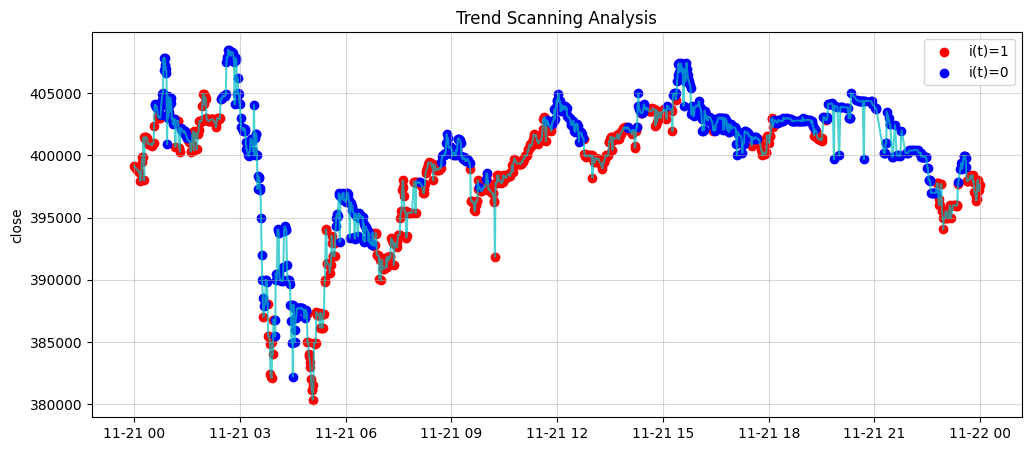

In [ ]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.plot(sub_data.sort_index(), color='c', alpha=0.7)
ax.scatter(sub_data.index[c_sig['color'] == 'red'], sub_data[c_sig['color'] == 'red'], c='red', label='i(t)=1')
ax.scatter(sub_data.index[c_sig['color'] == 'blue'], sub_data[c_sig['color'] == 'blue'], c='blue', label='i(t)=0')
ax.set_title("Trend Scanning Analysis")
ax.set_ylabel('close')
ax.grid(axis='both', alpha=0.5)
ax.legend()

위 그래프는 **2017년 11월 21일** 하루 동안의 이더리움 종가 데이터에 `Trend Scanning Analysis` 후 라벨링된  결과를 색상으로 나타낸 그래프이다.
- 빨간색 점 (i(t)=1): 기준 시점부터 look_forward_window(60분) 내 다양한 하위 구간 중 가장 통계적으로 유의미한 상승 추세가 나타난 시점을 의미한다.

- 파란색 점 (i(t)=0): 기준 시점부터 look_forward_window (60분) 내의 다양한 하위 구간 중 가장 통계적으로 유의미한 상승 추세가 아닌 시점(즉, 하락 추세가 나타난 시점)을 의미한다.




# 프로젝트 : Feature Engineering
___

① 환경구성 및 데이터 불러오기

② Technical Index 적용하기

③ Feature Selection methods 적용하기



## ① 환경구성 및 데이터 불러오기

환경구성 및 데이터를 불러옵니다.

In [ ]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

#import sys
#sys.path.append('/aiffel/aiffel/fnguide/data/')
#from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [ ]:
# 데이터 경로 설정
DATA_PATH = '/content/drive/MyDrive/DS/6.시계열/data/시계열_플젝'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

## ② Technical Index 적용하기
___
앞서 배운 기술적 지표와 수익률/변동성 지표를 참고하여 코드를 뜯어봅시다.

In [ ]:
# 기술적 지표를 적용합니다.

mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

/usr/local/lib/python3.12/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.12/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


In [ ]:
# 수익률 / 변동성 지표를 적용합니다.
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [ ]:
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1]
y = df_tmp_data.iloc[:, -1] # iloc[:, -1] 사용

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [ ]:
# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight='balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

③ Feature Selection methods 적용하기
___

MDI, Mean Decrease Impurity





In [ ]:
"""
mlfinlab
"""

"""
Module which implements feature importance algorithms as described in Chapter 8 of Advances in Financial Machine
Learning and Clustered Feature Importance algorithms as described in Chapter 6 Section 6.5.2 of Machine Learning for
Asset Managers.
"""

import pandas as pd
import numpy as np
from sklearn.metrics import log_loss


def mean_decrease_impurity(model, feature_names, clustered_subsets=None):
    """
    Advances in Financial Machine Learning, Snippet 8.2, page 115.
    MDI Feature importance
    Mean decrease impurity (MDI) is a fast, explanatory-importance (in-sample, IS) method specific to tree-based
    classifiers, like RF. At each node of each decision tree, the selected feature splits the subset it received in
    such a way that impurity is decreased. Therefore, we can derive for each decision tree how much of the overall
    impurity decrease can be assigned to each feature. And given that we have a forest of trees, we can average those
    values across all estimators and rank the features accordingly.
    Tip:
    Masking effects take place when some features are systematically ignored by tree-based classifiers in favor of
    others. In order to avoid them, set max_features=int(1) when using sklearn’s RF class. In this way, only one random
    feature is considered per level.
    Notes:
    * MDI cannot be generalized to other non-tree based classifiers
    * The procedure is obviously in-sample.
    * Every feature will have some importance, even if they have no predictive power whatsoever.
    * MDI has the nice property that feature importances add up to 1, and every feature importance is bounded between 0 and 1.
    * method does not address substitution effects in the presence of correlated features. MDI dilutes the importance of
      substitute features, because of their interchangeability: The importance of two identical features will be halved,
      as they are randomly chosen with equal probability.
    * Sklearn’s RandomForest class implements MDI as the default feature importance score. This choice is likely
      motivated by the ability to compute MDI on the fly, with minimum computational cost.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.4 page 86) :
    Clustered MDI  is the  modified version of MDI (Mean Decreased Impurity). It  is robust to substitution effect that
    takes place when two or more explanatory variables share a substantial amount of information (predictive power).CFI
    algorithm described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance section of book Machine Learning
    for Asset Manager. Here  instead of  taking the importance  of  every feature, we consider the importance of every
    feature subsets, thus every feature receive the importance of subset it belongs to.
    :param model: (model object): Trained tree based classifier.
    :param feature_names: (list): Array of feature names.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :return: (pd.DataFrame): Mean and standard deviation feature importance.
    """
    # Feature importance based on in-sample (IS) mean impurity reduction
    feature_imp_df = {i: tree.feature_importances_ for i, tree in enumerate(model.estimators_)}
    feature_imp_df = pd.DataFrame.from_dict(feature_imp_df, orient='index')
    feature_imp_df.columns = feature_names

    # Make sure that features with zero importance are not averaged, since the only reason for a 0 is that the feature
    # was not randomly chosen. Replace those values with np.nan
    feature_imp_df = feature_imp_df.replace(0, np.nan)  # Because max_features = 1

    if clustered_subsets is not None:
        # Getting subset wise importance
        importance = pd.DataFrame(index=feature_names, columns=['mean', 'std'])
        for subset in clustered_subsets: # Iterating over each cluster
            subset_feat_imp = feature_imp_df[subset].sum(axis=1)
            # Importance of each feature within a subsets is equal to the importance of that subset
            importance.loc[subset, 'mean'] = subset_feat_imp.mean()
            importance.loc[subset, 'std'] = subset_feat_imp.std()*subset_feat_imp.shape[0]**-.5
    else:
        importance = pd.concat({'mean': feature_imp_df.mean(),
                                'std': feature_imp_df.std() * feature_imp_df.shape[0] ** -0.5},
                               axis=1)

    importance /= importance['mean'].sum()
    return importance


def mean_decrease_accuracy(model, X, y, cv_gen, clustered_subsets=None, sample_weight_train=None,
                           sample_weight_score=None, scoring=log_loss, random_state=42):
    """
    Advances in Financial Machine Learning, Snippet 8.3, page 116-117.
    MDA Feature Importance
    Mean decrease accuracy (MDA) is a slow, predictive-importance (out-of-sample, OOS) method. First, it fits a
    classifier; second, it derives its performance OOS according to some performance score (accuracy, negative log-loss,
    etc.); third, it permutates each column of the features matrix (X), one column at a time, deriving the performance
    OOS after each column’s permutation. The importance of a feature is a function of the loss in performance caused by
    its column’s permutation. Some relevant considerations include:
    * This method can be applied to any classifier, not only tree-based classifiers.
    * MDA is not limited to accuracy as the sole performance score. For example, in the context of meta-labeling
      applications, we may prefer to score a classifier with F1 rather than accuracy. That is one reason a better
      descriptive name would have been “permutation importance.” When the scoring function does not correspond to a
      metric space, MDA results should be used as a ranking.
    * Like MDI, the procedure is also susceptible to substitution effects in the presence of correlated features.
      Given two identical features, MDA always considers one to be redundant to the other. Unfortunately, MDA will make
      both features appear to be outright irrelevant, even if they are critical.
    * Unlike MDI, it is possible that MDA concludes that all features are unimportant. That is because MDA is based on
      OOS performance.
    * The CV must be purged and embargoed.
    Clustered Feature Importance( Machine Learning for Asset Manager snippet 6.5 page 87) :
    Clustered MDA is the modified version of MDA (Mean Decreased Accuracy). It is robust to substitution effect that takes
    place when two or more explanatory variables share a substantial amount of information (predictive power).CFI algorithm
    described by Dr Marcos Lopez de Prado  in Clustered Feature  Importance (Presentation Slides)
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595. Instead of shuffling (permutating) all variables
    individually (like in MDA), we shuffle all variables in cluster together. Next, we follow all the  rest of the
    steps as in MDA. It can used by simply specifying the clustered_subsets argument.
    :param model: (sklearn.Classifier): Any sklearn classifier.
    :param X: (pd.DataFrame): Train set features.
    :param y: (pd.DataFrame, np.array): Train set labels.
    :param cv_gen: (cross_validation.PurgedKFold): Cross-validation object.
    :param clustered_subsets: (list) Feature clusters for Clustered Feature Importance (CFI). Default None will not apply CFI.
                              Structure of the input must be a list of list/s i.e. a list containing the clusters/subsets of feature
                              name/s inside a list. E.g- [['I_0','I_1','R_0','R_1'],['N_1','N_2'],['R_3']]
    :param sample_weight_train: (np.array) Sample weights used to train the model for each record in the dataset.
    :param sample_weight_score: (np.array) Sample weights used to evaluate the model quality.
    :param scoring: (function): Scoring function used to determine importance.
    :param random_state: (int) Random seed for shuffling the features.
    :return: (pd.DataFrame): Mean and standard deviation of feature importance.
    """

    if sample_weight_train is None:
        sample_weight_train = np.ones((X.shape[0],))

    if sample_weight_score is None:
        sample_weight_score = np.ones((X.shape[0],))

    fold_metrics_values, features_metrics_values = pd.Series(dtype='float64'), pd.DataFrame(columns=X.columns)
    # Generating a numpy random state object for the given random_state
    rs_obj = np.random.RandomState(seed=random_state)
    # Clustered feature subsets will be used for CFI if clustered_subsets exists else will operate on the single column as MDA
    feature_sets = clustered_subsets if clustered_subsets else [[x] for x in X.columns]
    for i, (train, test) in enumerate(cv_gen.split(X=X)):
        fit = model.fit(X=X.iloc[train, :], y=y.iloc[train], sample_weight=sample_weight_train[train])
        pred = fit.predict(X.iloc[test, :])

        # Get overall metrics value on out-of-sample fold
        if scoring == log_loss:
            prob = fit.predict_proba(X.iloc[test, :])
            fold_metrics_values.loc[i] = -scoring(y.iloc[test], prob, sample_weight=sample_weight_score[test],
                                                  labels=model.classes_)
        else:
            fold_metrics_values.loc[i] = scoring(y.iloc[test], pred, sample_weight=sample_weight_score[test])

        # Get feature specific metric on out-of-sample fold
        for j in feature_sets:
            X1_ = X.iloc[test, :].copy(deep=True)
            for j_i in j:
                rs_obj.shuffle(X1_[j_i].values)  # Permutation of a single column for MDA or through the whole subset for CFI
            if scoring == log_loss:
                prob = fit.predict_proba(X1_)
                features_metrics_values.loc[i, j] = -scoring(y.iloc[test], prob,
                                                             sample_weight=sample_weight_score[test],
                                                             labels=model.classes_)
            else:
                pred = fit.predict(X1_)
                features_metrics_values.loc[i, j] = scoring(y.iloc[test], pred,
                                                            sample_weight=sample_weight_score[test])

    importance = (-features_metrics_values).add(fold_metrics_values, axis=0)
    if scoring == log_loss:
        importance = importance / -features_metrics_values
    else:
        importance = importance / (1.0 - features_metrics_values).replace(0, np.nan)
    importance = pd.concat({'mean': importance.mean(), 'std': importance.std() * importance.shape[0] ** -.5}, axis=1)
    importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values

    return importance

In [ ]:
# MDI, Mean Decrease Impurity
feat_imp = mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.046254,0.001938
volume_fi,0.042738,0.002353
volume_mfi,0.046460,0.002299
volume_sma_em,0.037482,0.001826
volume_vpt,0.026924,0.001640
volatility_atr,0.079528,0.002987
volatility_ui,0.051093,0.002291
trend_macd_diff,0.079723,0.003618
trend_adx,0.052721,0.002418
trend_trix,0.065835,0.002880


MDA, Mean Decrease Accuracy





In [ ]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) # Tree 및 Support Vector Machine 외에 다른 분류기(classifier)를 사용해봅시다.
cv = KFold(n_splits=5) # n_splits을 변경해봅시다.
feat_imp_mda = mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

/tmp/ipython-input-2490012548.py:164: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  importance.replace([-np.inf, np.nan], 0, inplace=True)  # Replace infinite values


In [ ]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path)
    else:
        plt.show()

plot_feature_importance 함수를 사용하여 feat_imp와 feat_imp_mda를 확인해봅시다.






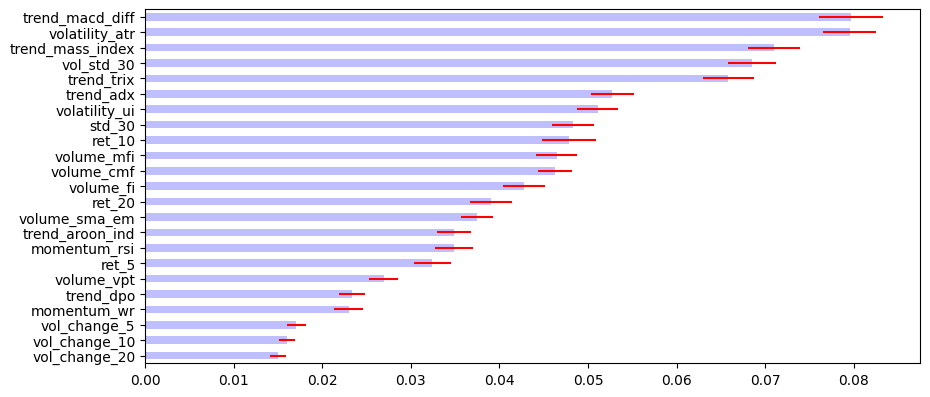

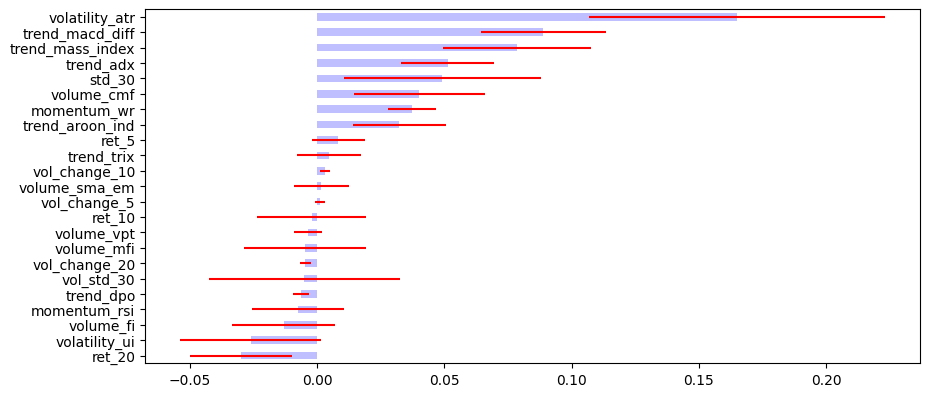

In [ ]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

RFE CV, Recursive Feature Elimination





In [ ]:
# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True)
cv = KFold(n_splits=5)

rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [ ]:
# 선택된 피쳐 확인하기
rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X_sc.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})
rfe_df[rfe_df['Optimal_Features']].index

Index(['volatility_atr', 'trend_macd_diff', 'std_30'], dtype='object')

SFS, Sequential Feature Selection





In [ ]:
# SFS, Sequential Feature Selection

n = 2
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=n, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

In [ ]:
# 선택된 피쳐 확인하기
sfs_rank = sfs_fitted.get_support()

sfs_df = pd.DataFrame(sfs_rank, index=X_sc.columns, columns=["Optimal_Features"])

sfs_df [sfs_df ["Optimal_Features"]==True].index

Index(['volume_mfi', 'trend_macd_diff'], dtype='object')

SHAP, Shapley Additive explanations





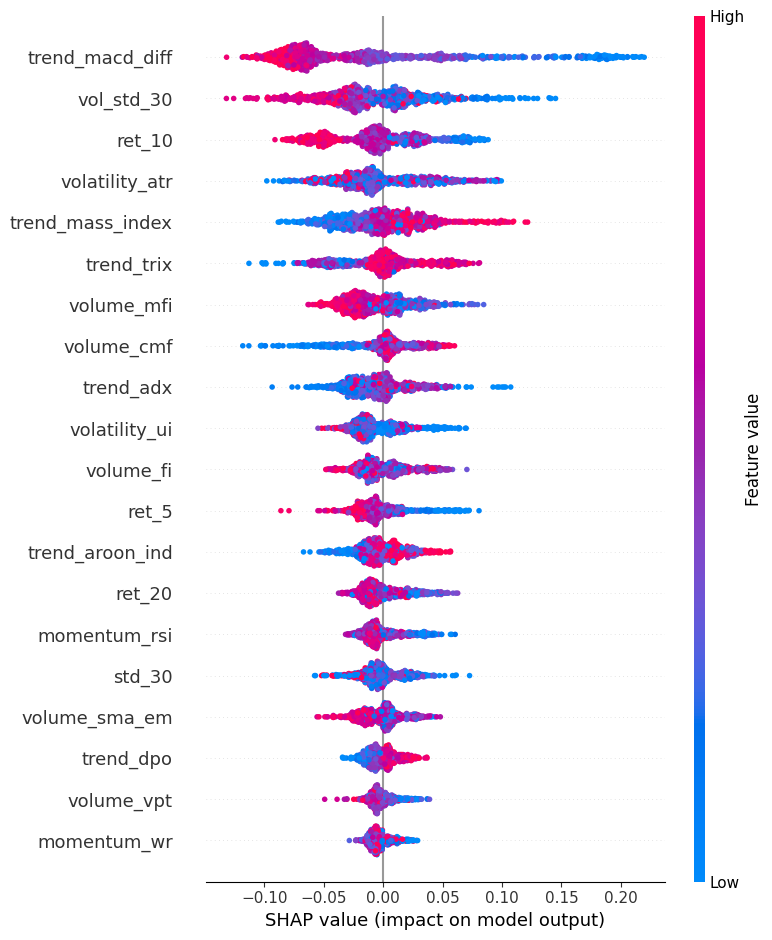

In [ ]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value[:, :, 0], X_sc, class_names='class 0') # class 0
#shap.summary_plot(shap_value[:, :, 1], X_sc, class_names='class 1') # class 1
#shap.summary_plot(shap_value[:, :, 2], X_sc, class_names='class 2') # class 2


# 3. 프로젝트 : Model Traning
___
① 환경구성 및 데이터 불러오기  
② Purged K-fold for Cross-Validation적용하기  
③ Model 적용하기

## ① 환경구성 및 데이터 불러오기


In [3]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

#sys.path.append('/aiffel/aiffel/fnguide/data/')
#from libs.mlutil.pkfold import PKFold

In [4]:
"""
Created on Fri Dec  6 19:41:30 2019

@author: sukji
"""
from typing import Callable
import pandas as pd
import numpy as np

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.base import ClassifierMixin
from sklearn.model_selection import BaseCrossValidator

def ml_get_train_times1(samples_info_sets: pd.Series, test_times: pd.Series) -> pd.Series:
    # pylint: disable=invalid-name
    """
    Advances in Financial Machine Learning, Snippet 7.1, page 106.

    Purging observations in the training set

    This function find the training set indexes given the information on which each record is based
    and the range for the test set.
    Given test_times, find the times of the training observations.

    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param test_times: (pd.Series) Times for the test dataset.
    :return: (pd.Series) Training set
    """
    train = samples_info_sets.copy(deep=True)

    start = test_times.min()
    end = test_times.max()

    first = test_times.index[0]
    last = test_times.index[-1]

    df0 = train[(train < first) | (train.index > end)].index  # Train starts within test
    return df0

class PKFold(KFold):
    """
    Extend KFold class to work with labels that span intervals

    The train is purged of observations overlapping test-label intervals
    Test set is assumed contiguous (shuffle=False), w/o training samples in between

    :param n_splits: (int) The number of splits. Default to 3
    :param samples_info_sets: (pd.Series) The information range on which each record is constructed from
        *samples_info_sets.index*: Time when the information extraction started.
        *samples_info_sets.value*: Time when the information extraction ended.
    :param pct_embargo: (float) Percent that determines the embargo size.
    """

    def __init__(self,
                 n_splits: int = 3,
                 samples_info_sets: pd.Series = None,
                 pct_embargo: float = 0.):

        if not isinstance(samples_info_sets, pd.Series):
            raise ValueError('The samples_info_sets param must be a pd.Series')
        super(PKFold, self).__init__(n_splits, shuffle=False, random_state=None)

        self.samples_info_sets = samples_info_sets
        self.pct_embargo = pct_embargo

    # noinspection PyPep8Naming
    def split(self,
              X: pd.DataFrame,
              y: pd.Series = None,
              groups=None):
        """
        The main method to call for the PurgedKFold class

        :param X: (pd.DataFrame) Samples dataset that is to be split
        :param y: (pd.Series) Sample labels series
        :param groups: (array-like), with shape (n_samples,), optional
            Group labels for the samples used while splitting the dataset into
            train/test set.
        :return: (tuple) [train list of sample indices, and test list of sample indices]
        """
        if X.shape[0] != self.samples_info_sets.shape[0]:
            raise ValueError("X and the 'samples_info_sets' series param must be the same length")

        indices: np.ndarray = np.arange(X.shape[0])
        embargo: int = int(X.shape[0] * self.pct_embargo)

        test_ranges: [(int, int)] = [(ix[0], ix[-1] + 1) for ix in np.array_split(np.arange(X.shape[0]), self.n_splits)]
        for start_ix, end_ix in test_ranges:
            test_indices = indices[start_ix:end_ix]

            if end_ix < X.shape[0]:
                end_ix += embargo

            test_times = pd.Series(index=[self.samples_info_sets.index[start_ix]], data=[self.samples_info_sets[end_ix-1]])
            #train_times = ml_get_train_times(self.samples_info_sets, test_times)
            train_times = ml_get_train_times1(self.samples_info_sets, test_times)

            train_indices = []
            for train_ix in train_times:
                train_indices.append(self.samples_info_sets.index.get_loc(train_ix))
            yield np.array(train_indices), test_indices

원 pkl파일을 다시 로드하여 진행

In [120]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/content/drive/MyDrive/DS/6.시계열/data/시계열_플젝'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_data = pd.read_pickle(data_file_name)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)
print(df_data['t_value'].value_counts())

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.8, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
#sc = StandardScaler()
#X_sc = sc.fit_transform(X)

# 데이터셋 분리
#train_x, test_x, train_y, test_y = X_sc[:n_train], X_sc[-n_test:], y.iloc[:n_train], y.iloc[-n_test:]
train_x, test_x, train_y, test_y = X[:n_train], X[-n_test:], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

t_value
1.0    481
0.0    476
Name: count, dtype: int64


In [121]:
df_data.shape, train_x.shape, test_x.shape, train_y.shape, test_y.shape

((957, 29), (718, 23), (191, 23), (718,), (191,))

## ② Purged K-fold for Cross-Validation적용하기
___

In [122]:
n_cv = 4 # 앞에서 지정한 값은 4입니다. 얼마를 넣을지 생각해보고 왜 이 값을 넣었는지에 대해서 설명해봅시다.
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold
cv = PKFold(n_cv, t1, 0)

n_cv 값을 4로 지정한 이유
1. 데이터셋 크기 고려: 샘플링된 train의 크기는 1000개로 약 11시간 동안 수집된 데이터이므로, 데이터 크기에 비해 폴드 수가 너무 많으면 학습이 원활히 안될 가능성이 있음
2. 성능 추정 균형: 폴드 수가 너무 적으면 모델은 안정적일 수 있지만 폴드를 통한 교차검증 효과가 낮아지는 편향이 발생할 수 있음  

따라서 cv 시 n_split의 기본값인 5보다 1 작은 4로 설정하였음

## ③ Model 적용하기
___


In [132]:
# GridsearchCV에서 사용할 파라미터 설정합니다. 파라미터값을 바꿔보세요
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'estimator__max_depth': [3,5,10,20],
             'estimator__max_features': [None, 'auto'],
             'estimator__min_samples_leaf': [3, 5, 10],
#             'bootstrap_features': [False, True]
             'bootstrap_features': [True]
            }

# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced', random_state=1)

# Bagging 적용
bag_rfc = BaggingClassifier(rfc, random_state=1)

# GridSearchCV 적용
#gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

In [133]:
bes_params = {'bootstrap': True,
 'bootstrap_features': True,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': 'balanced',
 'estimator__criterion': 'gini',
 'estimator__max_depth': 5,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 10,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=None,
                        min_samples_leaf=10),
 'max_features': 0.7,
 'max_samples': 1.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# fit
#gs_rfc.fit(train_x, train_y)
bag_rfc.set_params(**best_params)
bag_rfc.fit(train_x, train_y)

# best estimator
#gs_rfc_best = gs_rfc.best_estimator_
gs_rfc_best = bag_rfc

================= confusion matrix ====================
[[91 45]
 [10 45]]
정확도:0.7120, 정밀도:0.5000, 재현율:0.8182, AUC:0.8226


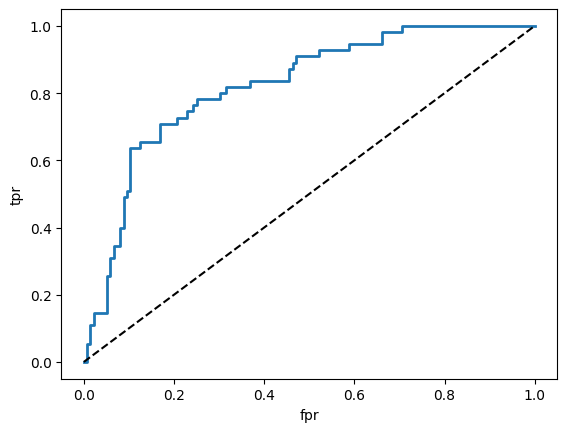

In [134]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

# test_y, pred_y를 활용한 지표 적용
def get_scores(test_y, pred_y, verbose = True):
    confusion = confusion_matrix(test_y, pred_y)
    accuracy  = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y)
    recall    = recall_score(test_y, pred_y)
    auc = roc_auc_score(test_y, prob_y[:,1])

    if verbose:
        print('================= confusion matrix ====================')
        print(confusion)
        print('=======================================================')
        print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}, AUC:{auc:.4f}')
        return accuracy, precision, recall, auc
    else:
        return accuracy, precision, recall, auc

scores = get_scores(test_y, pred_y)

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show()

base model의 best_params:  
```
{'bootstrap': True,
 'bootstrap_features': True,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': 'balanced',
 'estimator__criterion': 'gini',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 10,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(class_weight='balanced', max_depth=3, max_features=None,
                        min_samples_leaf=10),
 'max_features': 0.5,
 'max_samples': 1.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
 ```

base model + no scaling + PKFold(n_split=4) + training-_ratio(0.75) 모델의 best_params:
```
{'bootstrap': True,
 'bootstrap_features': True,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': 'balanced',
 'estimator__criterion': 'gini',
 'estimator__max_depth': 5,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 10,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__monotonic_cst': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(class_weight='balanced', max_depth=5, max_features=None,
                        min_samples_leaf=10),
 'max_features': 0.7,
 'max_samples': 1.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
 ```

### SHAP를 활용한 Feature Selection

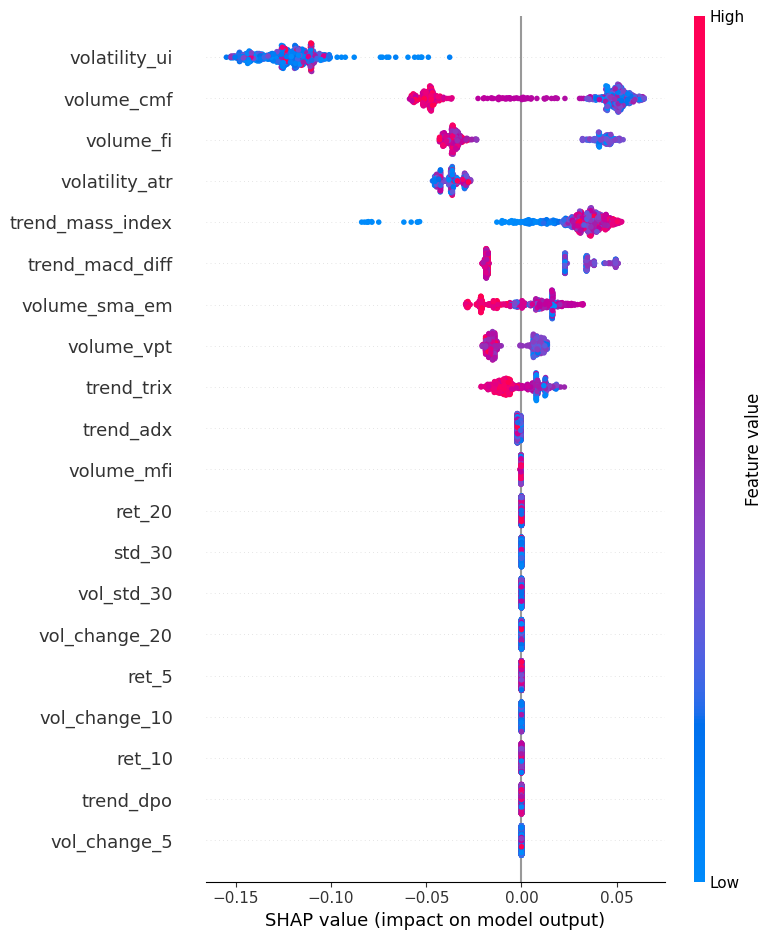

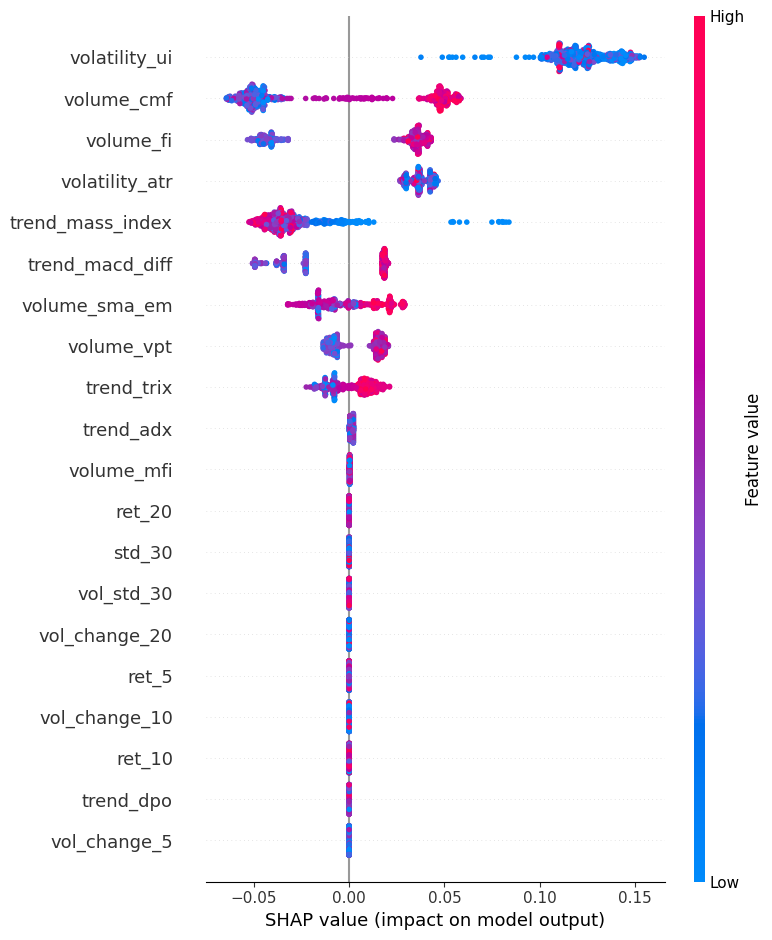

In [142]:
import shap

#best_rfc_model = gs_rfc_best.estimator # Original line
best_rfc_model = gs_rfc_best.estimators_[0] # Access the fitted base estimator from BaggingClassifier

# SHAP Explainer 생성 (트리 기반 모델에 최적화)
explainer = shap.TreeExplainer(best_rfc_model)

# SHAP 값 계산
shap_values = explainer.shap_values(train_x)

# SHAP 값을 이용한 특성 중요도 시각화
shap.summary_plot(shap_values[:, :, 0], train_x, class_names= 'class 0')
shap.summary_plot(shap_values[:, :, 1], train_x, class_names= 'class 1')

In [143]:
# 특성 이름과 SHAP 중요도 매핑
mean_shap = np.mean(np.abs(shap_values), axis=(0, 2))  # over samples and classes

shap_importance_df = pd.DataFrame({
    'feature': train_x.columns,
    'shap_importance': mean_shap
}).sort_values(by='shap_importance', ascending=False)

# 중요도가 높은 특성 선택 및 데이터 재구성
top_shap_features = shap_importance_df.head(10)['feature'].tolist()
print(top_shap_features)

['volatility_ui', 'volume_cmf', 'volume_fi', 'volatility_atr', 'trend_mass_index', 'trend_macd_diff', 'volume_sma_em', 'volume_vpt', 'trend_trix', 'trend_adx']


In [175]:
# 선택된 특성으로 모델 재학습
selected_train_x_shap = train_x[top_shap_features]
selected_test_x_shap = test_x[top_shap_features]

best_rfc_model.fit(selected_train_x_shap, train_y)

# Feature Selection 적용 전 모델의 성능
print("--- 기존 모델 성능 ---")
scores = get_scores(test_y, pred_y)

# Feature Selection 적용 후 모델의 성능
y_pred_fs = best_rfc_model.predict(selected_test_x_shap)
print("\n--- SHAP를 활용한 Feature Selection 적용 후 모델 성능 ---")
scores_fs = get_scores(test_y, y_pred_fs)

--- 기존 모델 성능 ---
================= confusion matrix ====================
[[91 45]
 [10 45]]
정확도:0.7120, 정밀도:0.5000, 재현율:0.8182, AUC:0.8226

--- SHAP를 활용한 Feature Selection 적용 후 모델 성능 ---
================= confusion matrix ====================
[[78 58]
 [13 42]]
정확도:0.6283, 정밀도:0.4200, 재현율:0.7636, AUC:0.8226


### Sequential Feature Selection

In [166]:
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

rfe_cv = RFECV(best_rfc_model, cv=cv)
rfe_fitted = rfe_cv.fit(train_x, train_y)

rfe_df = pd.DataFrame([rfe_fitted.support_, rfe_fitted.ranking_], columns=X.columns).T.rename(columns={0:"Optimal_Features", 1:"Ranking"})

In [172]:
display(rfe_df[rfe_df['Optimal_Features']])

opt_features = rfe_df[rfe_df['Optimal_Features']].index.values

,Optimal_Features,Ranking
volume_cmf,True,1
volume_fi,True,1
volume_mfi,True,1
volatility_atr,True,1
volatility_ui,True,1
trend_macd_diff,True,1
trend_adx,True,1
trend_trix,True,1
trend_mass_index,True,1
momentum_rsi,True,1


In [174]:
# 선택된 특성으로 모델 재학습
selected_train_x_sfe = train_x[opt_features]
selected_test_x_sfe = test_x[opt_features]

best_rfc_model.fit(selected_train_x_sfe, train_y)

# Feature Selection 적용 전 모델의 성능
print("--- 기존 모델 성능 ---")
scores = get_scores(test_y, pred_y)

# Feature Selection 적용 후 모델의 성능
y_pred_fs = best_rfc_model.predict(selected_test_x_sfe)
print("\n--- Sequential Feature Selection 적용 후 모델 성능 ---")
scores_fs = get_scores(test_y, y_pred_fs)

--- 기존 모델 성능 ---
================= confusion matrix ====================
[[91 45]
 [10 45]]
정확도:0.7120, 정밀도:0.5000, 재현율:0.8182, AUC:0.8226

--- Sequential Feature Selection 적용 후 모델 성능 ---
================= confusion matrix ====================
[[83 53]
 [14 41]]
정확도:0.6492, 정밀도:0.4362, 재현율:0.7455, AUC:0.8226


## optuna를 활용한 tuning

In [185]:
! pip install -U optuna


In [186]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/content/drive/MyDrive/DS/6.시계열/data/시계열_플젝'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')
df_data = pd.read_pickle(data_file_name)

# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)
print(df_data['t_value'].value_counts())

# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.8, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
#sc = StandardScaler()
#X_sc = sc.fit_transform(X)

# 데이터셋 분리
#train_x, test_x, train_y, test_y = X_sc[:n_train], X_sc[-n_test:], y.iloc[:n_train], y.iloc[-n_test:]
train_x, test_x, train_y, test_y = X[:n_train], X[-n_test:], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

t_value
1.0    481
0.0    476
Name: count, dtype: int64


In [188]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

def objective(trial):
    # Optuna가 제안할 파라미터 범위 정의
    # Parameters for BaggingClassifier
    n_estimators_bagging = trial.suggest_int('n_estimators_bagging', 5, 100)
    max_features_bagging = trial.suggest_float('max_features_bagging', 0.5, 1.0) # Use float for max_features

    # Parameters for the base RandomForestClassifier
    max_depth_rf = trial.suggest_int('max_depth_rf', 3, 20)
    min_samples_split_rf = trial.suggest_int('min_samples_split_rf', 2, 10)
    min_samples_leaf_rf = trial.suggest_int('min_samples_leaf_rf', 1, 10) # Increased range for min_samples_leaf

    # RandomForestClassifier 모델 정의 (base estimator)
    rfc = RandomForestClassifier(
        max_depth=max_depth_rf,
        min_samples_split=min_samples_split_rf,
        min_samples_leaf=min_samples_leaf_rf,
        class_weight='balanced',
        random_state=42
    )

    # BaggingClassifier 모델 정의
    bag_rfc = BaggingClassifier(
        estimator=rfc, # Use the defined RandomForestClassifier as the base estimator
        n_estimators=n_estimators_bagging,
        max_features=max_features_bagging,
        random_state=42,
        n_jobs=-1 # Use all available cores
    )

    # purged K-Fold
    t1 = pd.Series(train_y.index.values, index=train_y.index)
    cv = PKFold(4, t1, 0)

    # 교차 검증을 통해 성능 평가
    # Use train_x and train_y with cross_val_score
    score = cross_val_score(bag_rfc, train_x, train_y, cv=cv, scoring='accuracy', n_jobs=-1) # Use the PKFold cv object
    accuracy = score.mean()

    return accuracy

In [191]:
# 1시간 소요...
from tqdm.auto import tqdm

# 'maximize' 방향으로 스터디 생성
study = optuna.create_study(direction='maximize')

# for _ in tqdm(range(100), desc="Optuna Optimization"):
#     study.optimize(objective, n_trials=1) # Run one trial at a time

# -- tuning 결과 --
study.best_params = {
    'n_estimators_bagging': 66,
    'max_features_bagging': 0.9101717674430383,
    'max_depth_rf': 13,
    'min_samples_split_rf': 7,
    'min_samples_leaf_rf': 5}
study.best_value = 0.6161

print("최적의 파라미터:", study.best_params)
print("최고 정확도:", study.best_value)

#최적의 파라미터: {'n_estimators_bagging': 66, 'max_features_bagging': 0.9101717674430383, 'max_depth_rf': 13, 'min_samples_split_rf': 7, 'min_samples_leaf_rf': 5}
#최고 정확도: 0.6161

[I 2025-09-15 14:42:29,419] A new study created in memory with name: no-name-3879be22-5eee-4171-a458-873a3d8ea738


Optuna Optimization:   0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-09-15 14:43:19,004] Trial 0 finished with value: 0.6109361365619546 and parameters: {'n_estimators_bagging': 57, 'max_features_bagging': 0.8694152746518993, 'max_depth_rf': 13, 'min_samples_split_rf': 2, 'min_samples_leaf_rf': 4}. Best is trial 0 with value: 0.6109361365619546.
[I 2025-09-15 14:43:30,490] Trial 1 finished with value: 0.5847717604712042 and parameters: {'n_estimators_bagging': 14, 'max_features_bagging': 0.7451011818936708, 'max_depth_rf': 14, 'min_samples_split_rf': 5, 'min_samples_leaf_rf': 9}. Best is trial 0 with value: 0.6109361365619546.
[I 2025-09-15 14:44:26,806] Trial 2 finished with value: 0.5978471313263526 and parameters: {'n_estimators_bagging': 75, 'max_features_bagging': 0.8143334883349649, 'max_depth_rf': 9, 'min_samples_split_rf': 4, 'min_samples_leaf_rf': 2}. Best is trial 0 with value: 0.6109361365619546.
[I 2025-09-15 14:44:47,932] Trial 3 finished with value: 0.608277432373473 and parameters: {'n_estimators_bagging': 38, 'max_features_baggin

최적의 파라미터: {'n_estimators_bagging': 66, 'max_features_bagging': 0.9101717674430383, 'max_depth_rf': 13, 'min_samples_split_rf': 7, 'min_samples_leaf_rf': 5}
최고 정확도: 0.6161444698952879


              precision    recall  f1-score   support

         0.0       0.91      0.61      0.73       136
         1.0       0.47      0.85      0.61        55

    accuracy                           0.68       191
   macro avg       0.69      0.73      0.67       191
weighted avg       0.78      0.68      0.70       191

================= confusion matrix ====================
[[83 53]
 [ 8 47]]
정확도:0.6806, 정밀도:0.4700, 재현율:0.8545, AUC:0.8201


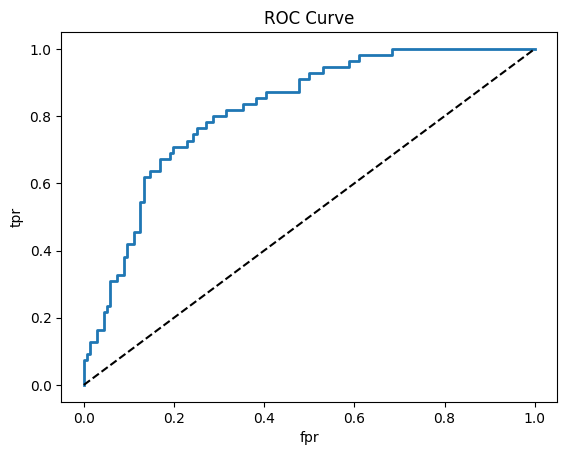

In [193]:
from sklearn.metrics import classification_report

best_params = study.best_params

# Extract parameters for the base RandomForestClassifier
best_rf_params = {
    'max_depth': best_params['max_depth_rf'],
    'min_samples_split': best_params['min_samples_split_rf'],
    'min_samples_leaf': best_params['min_samples_leaf_rf'],
    'class_weight': 'balanced',
    'random_state': 42
}

# Extract parameters for the BaggingClassifier
best_bagging_params = {
    'n_estimators': best_params['n_estimators_bagging'],
    'max_features': best_params['max_features_bagging'],
    'random_state': 42,
    'n_jobs': -1
}

# 재학습
best_rfc_base = RandomForestClassifier(**best_rf_params)
best_bagging_model = BaggingClassifier(estimator=best_rfc_base, **best_bagging_params)
best_bagging_model.fit(train_x, train_y)

# 테스트 데이터로 예측 및 성능 평가
y_pred = best_bagging_model.predict(test_x)
prob_y = best_bagging_model.predict_proba(test_x) # Calculate probabilities for AUC

scores = get_scores(test_y, y_pred, prob_y)

# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, prob_y[:,1])

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.show()

### PCA를 활용한 PCA extraction

- 특징 간 선형 관계가 존재한다고 가정
- PCA를 활용하여 차원축소를 시도하였음

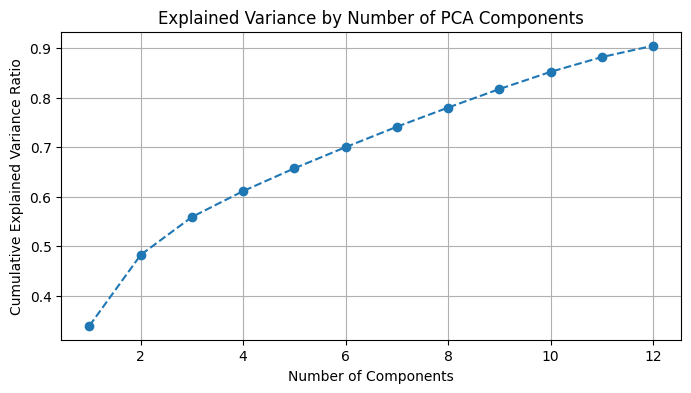


--- Model Performance after PCA ---
================= confusion matrix ====================
[[86 50]
 [ 6 49]]
정확도:0.7068, 정밀도:0.4949, 재현율:0.8909, AUC:0.8028


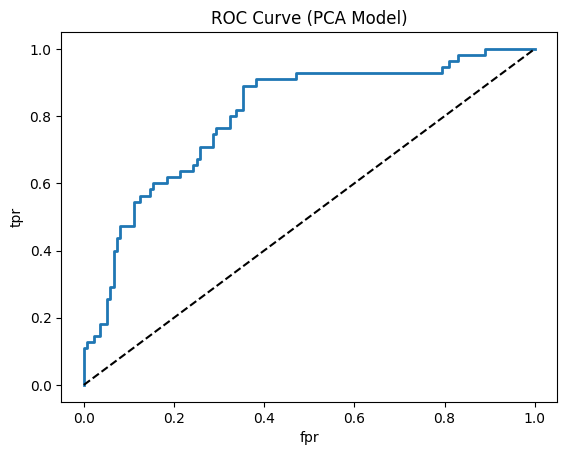

In [201]:
from sklearn.decomposition import PCA

# Scaling
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# PCA
pca = PCA(n_components=0.9) # 90% 이상이 되는 시점의 주성분으로 자동 결정
train_x_pca = pca.fit_transform(train_x_scaled)
test_x_pca = pca.transform(test_x_scaled)

# Explained variance Plot
explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o', linestyle='--')
plt.title('Explained Variance by Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()


# PCA로 학습
best_rfc_base = RandomForestClassifier(**best_rf_params)
best_bagging_model_pca = BaggingClassifier(estimator=best_rfc_base, **best_bagging_params)
best_bagging_model_pca.fit(train_x_pca, train_y)

# Evaluate the model on the PCA-transformed testing data
y_pred_pca = best_bagging_model_pca.predict(test_x_pca)
prob_y_pca = best_bagging_model_pca.predict_proba(test_x_pca) # Calculate probabilities for AUC

print("\n--- Model Performance after PCA ---")
# Use the get_scores function (assuming it's defined in a previous cell or define it here)
# Define get_scores function if not already defined
def get_scores(test_y, pred_y, prob_y, verbose = True):
    confusion = confusion_matrix(test_y, pred_y)
    accuracy  = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y)
    recall    = recall_score(test_y, pred_y)
    auc = roc_auc_score(test_y, prob_y[:,1])

    if verbose:
        print('================= confusion matrix ====================')
        print(confusion)
        print('=======================================================')
        print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}, AUC:{auc:.4f}')
        return accuracy, precision, recall, auc
    else:
        return accuracy, precision, recall, auc

scores_pca = get_scores(test_y, y_pred_pca, prob_y_pca)

# ROC curve for PCA model
fpr_pca, tpr_pca, thresholds_pca = roc_curve(test_y, prob_y_pca[:,1])

# ROC curve visualization for PCA model
plt.plot(fpr_pca, tpr_pca, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve (PCA Model)')
plt.show()

# 결과기록
# n_components=0.95 --> 정확도:0.6754, 정밀도:0.4667, 재현율:0.8909, AUC:0.7865
# n_components=0.90 --> 정확도:0.7068, 정밀도:0.4949, 재현율:0.8909, AUC:0.8028
# n_components=0.85 --> 정확도:0.6649, 정밀도:0.4505, 재현율:0.7455, AUC:0.7524


### 결과 기록


In [207]:
# base model 성능
res = {}
# -- GridSearchCV 활용 --
res['base'] = {'정확도':0.6806, '정밀도':0.465, '재현율':0.7455, 'AUC': 0.7743}
res['base+no_scaling'] = {'정확도':0.6963, '정밀도':0.4835, '재현율':0.8000, 'AUC': 0.8386} # 스케일링 생략
res['base+no_scaling+train_ratio+five_fold'] = {'정확도':0.6754, '정밀도':0.4639, '재현율':0.8182, 'AUC': 0.8385} # 스케일링 생략 + PKFold(n=5)
res['base+no_scaling+train_ratio'] = {'정확도':0.7120, '정밀도':0.5000, '재현율':0.8182, 'AUC': 0.8226} # 스케일링 생략 + train ratio 조정(0.70 --> 0.75)
res['base+no_scaling+train_ratio+three_fold'] = {'정확도':0.6702, '정밀도':0.4615, '재현율':0.8727, 'AUC': 0.8374} # 스케일링 생략 + train ratio 조정(0.70 --> 0.75) + PKFold(n=3)
res['base+no_scaling+train_ratio+FE(SHAP)'] = {'정확도':0.6283, '정밀도':0.4200, '재현율':0.7636, 'AUC': 0.8226} # 스케일링 생략 + train ratio 조정(0.70 --> 0.75) + FE(SHAP)
res['base+no_scaling+train_ratio+FE(SFE)'] = {'정확도':0.6492, '정밀도':0.4362, '재현율':0.7455, 'AUC': 0.8226} # 스케일링 생략 + train ratio 조정(0.70 --> 0.75) + FE(SFE)
# -- optuna 활용 --
res['base+no_scaling+train_ratio_2'] = {'정확도':0.6806, '정밀도':0.4700, '재현율':0.8545, 'AUC': 0.8201} # 스케일링 생략 + train ratio 조정(0.75 --> 0.80)
res['PCA+training_ratio'] = {'정확도':0.7068, '정밀도':0.4949, '재현율':0.8909, 'AUC':0.8028} # optuna로 튜닝한 모델 + PCA components + train ratio 조정(0.75 --> 0.80)
print(pd.DataFrame(res).T.sort_values('정확도', ascending=False))



                                           정확도     정밀도     재현율     AUC
base+no_scaling+train_ratio             0.7120  0.5000  0.8182  0.8226
PCA+training_ratio                      0.7068  0.4949  0.8909  0.8028
base+no_scaling                         0.6963  0.4835  0.8000  0.8386
base                                    0.6806  0.4650  0.7455  0.7743
base+no_scaling+train_ratio_2           0.6806  0.4700  0.8545  0.8201
base+no_scaling+train_ratio+five_fold   0.6754  0.4639  0.8182  0.8385
base+no_scaling+train_ratio+three_fold  0.6702  0.4615  0.8727  0.8374
base+no_scaling+train_ratio+FE(SFE)     0.6492  0.4362  0.7455  0.8226
base+no_scaling+train_ratio+FE(SHAP)    0.6283  0.4200  0.7636  0.8226


# 결과 정리
___
1.기본 모델 ('base') 대비 개선:
  - baseline 모델과 비교했을 때, 스케일링을 생략하고 학습 데이터 비율을 상향 조정한 모델들의 분류 성능이 전반적으로 향상되었다.
  - 그 중에서도 스케일링을 생략하고 학습데이터의 비율을 0.75로 상향 조정한 'base+no_scaling+train_ratio' 모델이 가장 높은 정확도를 달성했다.  

2.PKFold n_splits 변화:
- PKFold의 n_splits을 3부터 5까지 변경하며 n_splits에 따른 분류 성능을 비교하였으나 유의미한 차이는 발견하지 못했다.
  - 'base+no_scaling+train_ratio+three_fold' (PKFold n=3)
  - 'base+no_scaling' (PKFold n=4)
  - 'base+no_scaling+train_ratio+five_fold' (PKFold n=5),
- random_state를 미리 고정시킨 후 실험을 진행했으면 어땠을까 하는 아쉬움이 있다.

3.Feature Engineering 및 Selection:
- SHAP, SFE 등 Feature Selection 방법을 활용한 모델들은 기존 모델들보다 정확도가 낮게 나왔다.
  - 이는 선택되지 못한 Feature들이 가진 정보 loss로 인해 현재 데이터셋에서는 성능 개선에 큰 도움이 되지 않았다고 해석할 수 있다.

- PCA를 적용한 모델의 정확도는 'base+no_scaling+train_ratio'보다 약간 낮지만, 재현율이 0.8909로 가장 높아 실제 양성 클래스를 잘 탐지하는 데 강점을 보였으며, AUC도 비교적 높게 유지되었다.

4.학습 데이터 비율 변화 ('train_ratio'):
- base code에 보면 train/test의 비율이 0.7 그리고 0.2로 설정되어 있었다. 이 설정에 의도가 있을 것으로 보여서 처음에는 수정하지 않다가 다양한 실험에도 성능 개선 효과가 미비하여 학습 데이터의 비율도 조정하며 실험하였다.
- 전반적으로 학습 데이터 비율을 상향 조정했을 때 정확도가 상승했다.

5.클래스 0 예측 성능 관련:   
- 이번 프로젝트에서는 시계열 데이터에 대한 전처리보다는 다양한 특징 선택/추출 방법과 처음 접해보는 RandomForest + Bagging 모델을 활용한 학습에 집중하였다.
- 다양한 실험을 진행하였음에도 클래스 0에 대한 예측 성능은 늘 저조했다.
- 학습 및 tuning 시 scoring을 'precision'으로 했어야 했나 하는 아쉬움이 있다.